In [102]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.util import get_feature_score, perform_pca, get_clusters
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d, downsampling_plot
from subpred.pssm import calculate_pssms_notebook

import pandas as pd

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport", "Electron transport", "Potassium transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="keep",
    verbose=True,
    tax_ids_filter=[3702],
    output_log="../logs/meta_amino_sugar_dataset.log",
    # outliers=outliers,
    # sequence_clustering=70
)

In [3]:
df.keywords_transport.value_counts()

Sugar transport                                       118
Electron transport                                     62
Ion transport;Potassium transport                      62
Amino-acid transport                                   54
Electron transport;Ion transport                        8
Ion transport;Potassium transport;Sodium transport      6
Name: keywords_transport, dtype: int64

There are no multi-substrate transporters that transport two of the four substrates, but there are electron and potassium transporters that are labeled as ion transporters 

## Analysis of the entire dataset

In [4]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

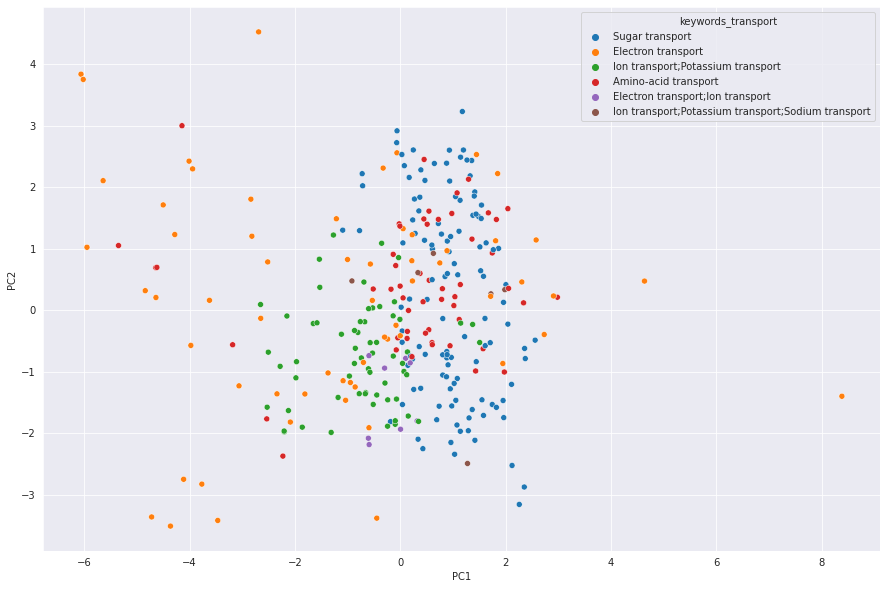

In [5]:
pca_plot_2d(df_aac, df.keywords_transport, figsize=(15,10))

In [6]:
df.tcdb_class.value_counts()

0.0    211
2.A     76
1.A     14
3.D      4
5.B      4
5.A      1
Name: tcdb_class, dtype: int64

({'Amino-acid transport': 'cyan',
  'Electron transport': 'magenta',
  'Electron transport;Ion transport': 'yellow',
  'Ion transport;Potassium transport': 'green',
  'Ion transport;Potassium transport;Sodium transport': 'orange',
  'Sugar transport': 'red'},
 <seaborn.matrix.ClusterGrid at 0x7f4bf88319a0>)

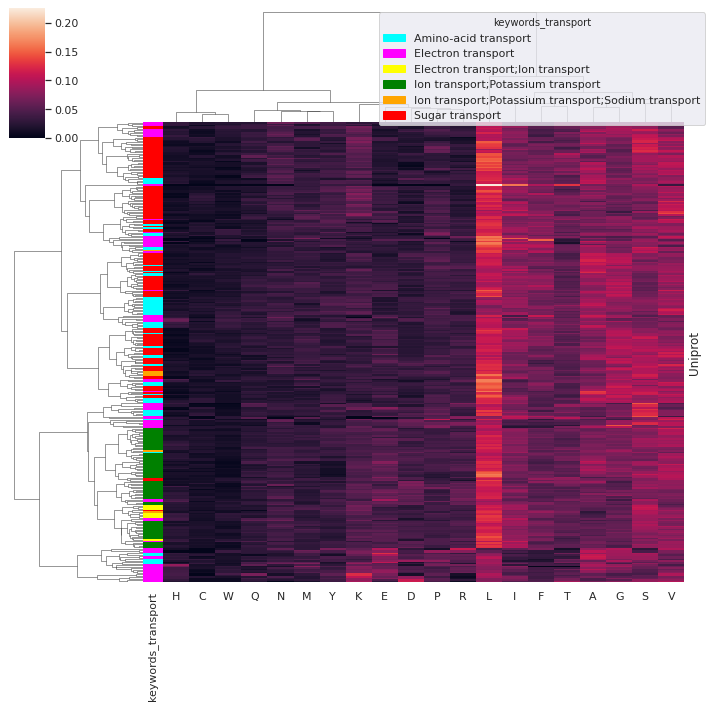

In [72]:
labeled_clustermap(df_aac, df.keywords_transport, xlabels="auto")

({'Amino-acid transport': 'cyan',
  'Electron transport': 'magenta',
  'Electron transport;Ion transport': 'yellow',
  'Ion transport;Potassium transport': 'green',
  'Ion transport;Potassium transport;Sodium transport': 'orange',
  'Sugar transport': 'red'},
 <seaborn.matrix.ClusterGrid at 0x7f4be93431f0>)

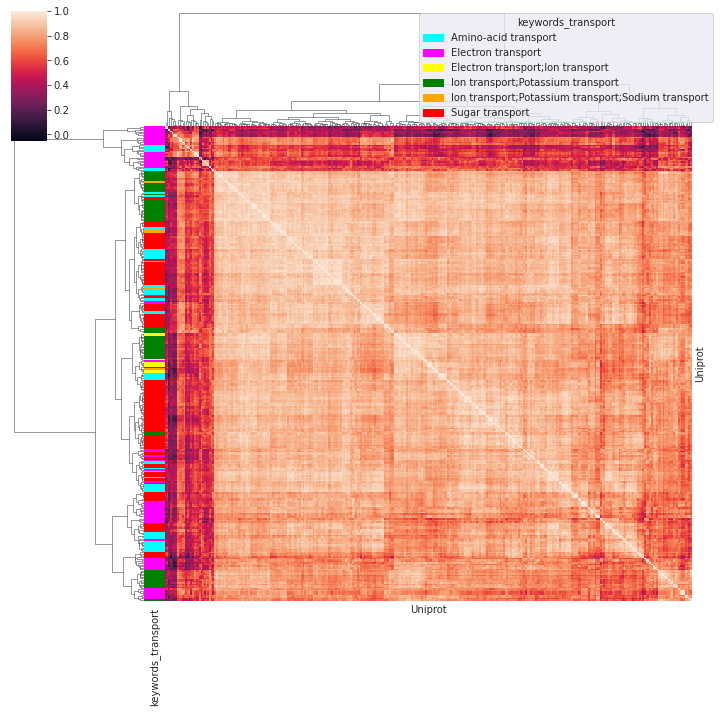

In [7]:
labeled_clustermap(df_aac.T.corr(), df.keywords_transport)

What are the proteins with low correlation to the rest of the dataset?

In [13]:
cluster1, cluster2 = get_clusters(df_aac.T.corr(), 2)

print(df.loc[cluster2].keywords_transport.value_counts())
print()
print(df.loc[cluster2].keywords_transport_related.value_counts())
print()
print(df.loc[cluster2].keywords_location.value_counts())

df_cluster1 = df.loc[cluster1]
df_cluster2 = df.loc[cluster2]

display(df_cluster2[df_cluster2.protein_names.str.startswith("NADH")])
display(df_cluster2[df_cluster2.protein_names.str.startswith("Ubi")])
display(df_cluster2[df_cluster2.protein_names.str.startswith("Cyto")])
display(df_cluster2[df_cluster2.gene_names.str.startswith("GDU")])

Electron transport      22
Amino-acid transport     7
Name: keywords_transport, dtype: int64

Respiratory chain;Transport    15
Transport                      14
Name: keywords_transport_related, dtype: int64

Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane    14
Membrane;Transmembrane                                               10
Endoplasmic reticulum;Membrane;Transmembrane                          3
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane            1
Cell membrane;Membrane;Transmembrane                                  1
Name: keywords_location, dtype: int64


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q8RWA7,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,MEE4 At1g04630 T1G11.12,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,3.D.1.6.3,3.D,3702,MTEAMIRNKPGMASVKDMPLLQDGPPPGGFAPVRYARRISNTGPSA...
Q9FGK0,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,At5g47570 MNJ7.16,NADH dehydrogenase [ubiquinone] 1 beta subcomp...,NaN,0.0,3702,MAGRLSGVASRIMGGNGVVARSVGSSLRQRAGMGLPVGKHIVPDKP...
O49313,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,At2g33220 F25I18.4,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,NaN,0.0,3702,MTEAMIRKKPGMASVKDMPLLQDGPPPGGFAPVRYARRISNTGPSA...
Q9C9Z5,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,At3g08610 F17O14.8,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,3.D.1.6.3,3.D,3702,MSLVWLEAMLPLGIIGGMLCIMGNSQYYIHKAYHGRPKHIGHDEWD...
Q9M9R9,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,At1g14450 F14L17.22,NADH dehydrogenase [ubiquinone] 1 beta subcomp...,NaN,0.0,3702,MAKPLGTTGEFFRRRDEWRKHPMLSNQMRHALPGLGIGVAAFCVYL...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O22048,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,AOX1C At3g27620 MGF10.3,"Ubiquinol oxidase 1c, mitochondrial (EC 1.10.3...",NaN,0.0,3702,MITTLLRRSLLDASKQATSINGILFHQLAPAKYFRVPAVGGLRDFS...
Q39219,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,AOX1A AOX1 HSR3 At3g22370 MCB17.11,"Ubiquinol oxidase 1a, mitochondrial (EC 1.10.3...",NaN,0.0,3702,MMITRGGAKAAKSLLVAAGPRLFSTVRTVSSHEALSASHILKPGVT...
O22049,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,AOX2 At5g64210 MSJ1.5,"Ubiquinol oxidase 2, mitochondrial (EC 1.10.3....",NaN,0.0,3702,MSQLITKAALRVLLVCGRGNCNMFVSSVSSTSVMKSPYEITAPMRI...
O23913,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,AOX1B At3g22360 MCB17.10,"Ubiquinol oxidase 1b, mitochondrial (EC 1.10.3...",NaN,0.0,3702,MMMSRRYGAKLMETAVTHSHLLNPRVPLVTENIRVPAMGVVRVFSK...
Q56X52,Electron transport,Membrane;Transmembrane,Respiratory chain;Transport,AOX4 IM PTOX At4g22260 T10I14_90,"Ubiquinol oxidase 4, chloroplastic/chromoplast...",NaN,0.0,3702,MAAISGISSGTLTISRPLVTLRRSRAAVSYSSSHRLLHHLPLSSRR...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9LXJ2,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,QCR9 At3g52730 F3C22.130,"Cytochrome b-c1 complex subunit 9, mitochondri...",NaN,0.0,3702,MEYAARRNQKGAFEGFYKLIMRRNSVYVTFIIAGAFFGERAVDYGV...
P56779,Electron transport,Membrane;Transmembrane,Transport,psbE AtCg00580,Cytochrome b559 subunit alpha (PSII reaction c...,NaN,0.0,3702,MSGSTGERSFADIITSIRYWVIHSITIPSLFIAGWLFVSTGLAYDV...
Q9SG91,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,UCRQ-1 At3g10860 T7M13.6,"Cytochrome b-c1 complex subunit 8-1, mitochond...",NaN,0.0,3702,MGKQPVKLKAVVYALSPFQQKIMTGLWKDLPEKIHHKVSENWISAT...
P62095,Electron transport,Membrane;Transmembrane,Transport,psbF AtCg00570,Cytochrome b559 subunit beta (PSII reaction ce...,NaN,0.0,3702,MTIDRTYPIFTVRWLAVHGLAVPTVSFLGSISAMQFIQR
Q9LK29,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,CYC1-1 At3g27240 K17E12.6,"Cytochrome c1 1, heme protein, mitochondrial (...",NaN,0.0,3702,MVGGGVIQQILRRKLHSQSLATPVLSWFSSKKAHEDAGSSGVRALA...
Q42342,Electron transport,Cell membrane;Endoplasmic reticulum;Membrane;T...,Transport,CYTB5-E B5-A CB5-A CB5-E At5g53560 MNC6.10,Cytochrome b5 isoform E (AtCb5-E) (Cytochrome ...,NaN,0.0,3702,MSSDRKVLSFEEVSKHNKTKDCWLIISGKVYDVTPFMDDHPGGDEV...
Q9ZNV4,Electron transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,CYTB5-C CB5-C At2g46650 T3A4.3,Cytochrome B5 isoform C (AtCb5-C),NaN,0.0,3702,MANLISFHDVAKHKCKNDCWILIHGKVYDISTFMDEHPGGDNVLLA...
Q9FKS5,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,CYC1-2 At5g40810 MHK7.4,"Cytochrome c1 2, heme protein, mitochondrial (...",NaN,0.0,3702,MVGGGVIRQLLRRKLHSQSVATPVLSWLSSKKANEDAGSAGLRAFA...
Q9ZWT2,Electron transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,CYTB5-D B5-B CB5-B CB5-D At5g48810 K24G6.14,Cytochrome B5 isoform D (AtCb5-D) (Cytochrome ...,NaN,0.0,3702,MGGDGKVFTLSEVSQHSSAKDCWIVIDGKVYDVTKFLDDHPGGDEV...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,0.0,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


Stats for the bigger cluster

In [9]:
print(df.loc[cluster1].keywords_transport.value_counts())
print()
print(df.loc[cluster1].keywords_transport_related.value_counts())
print()
print(df.loc[cluster1].keywords_location.value_counts())

Sugar transport                                       118
Ion transport;Potassium transport                      62
Amino-acid transport                                   47
Electron transport                                     40
Electron transport;Ion transport                        8
Ion transport;Potassium transport;Sodium transport      6
Name: keywords_transport, dtype: int64

Transport                                                        157
Antiport;Transport                                                56
Symport;Transport                                                 41
Respiratory chain;Transport                                       12
Ion channel;Potassium channel;Transport;Voltage-gated channel      9
Ion channel;Potassium channel;Transport                            6
Name: keywords_transport_related, dtype: int64

Membrane;Transmembrane                                               174
Cell membrane;Membrane;Transmembrane                                  73
Memb

### What are the proteins with low correlation to the rest of the dataset?

- The seven GDU proteins that we previously classified as outliers, we should remove them again.
- Ubiquinol oxidase
- Cytochrome B5
- Cytochrome C1
- NADH dehydrogenase 1

The types of protein that seems to be somewhat exclusive to the first cluster are the Ubiquinol oxidases, with only one protein in the larger cluster and the chains of "NADH dehydrogenase 1". The larger cluster also contains cytochrome chains, and NADH dehydrogenase chains. Here are similar proteins in cluster1 (in terms of name/function).

In [14]:
display(df_cluster1[df_cluster1.protein_names.str.startswith("NADH")])
display(df_cluster1[df_cluster1.protein_names.str.startswith("Ubi")])
display(df_cluster1[df_cluster1.protein_names.str.startswith("Cyto")])
display(df_cluster1[df_cluster1.gene_names.str.startswith("GDU")])

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P93313,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,ND4 NAD4 AtMg00580,NADH-ubiquinone oxidoreductase chain 4 (EC 7.1...,NaN,0.0,3702,MLEHFCECYFNLSGLILCPVLGSIILLFIPNSRIRLIRLIGLCASL...
P60497,Electron transport,Membrane;Mitochondrion;Transmembrane,Respiratory chain;Transport,ND6 NAD6 AtMg00270,NADH-ubiquinone oxidoreductase chain 6 (EC 7.1...,NaN,0.0,3702,MILSVLSSLALVSGLMVVRAKNPVHSVLFFILVFCDTSGLLLLLGL...
P92533,Electron transport,Membrane;Mitochondrion;Transmembrane,Respiratory chain;Transport,ND3 NAD3 AtMg00990,NADH-ubiquinone oxidoreductase chain 3 (EC 7.1...,NaN,0.0,3702,MMLEFAPIFIYLVISLLVSLILLGVPFLFASNSSTYPEKLSAYECG...
O05000,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,ND2 NAD2 AtMg00285/AtMg01320,NADH-ubiquinone oxidoreductase chain 2 (EC 7.1...,NaN,0.0,3702,MKAEFVRILPHMFNLFLAVFPEIFIINATFILLIHGVVFSTSKKYD...
Q04614,Electron transport,Membrane;Mitochondrion;Transmembrane,Respiratory chain;Transport,ND4L NAD4L AtMg00650,NADH-ubiquinone oxidoreductase chain 4L (EC 7....,NaN,0.0,3702,MDLIKYFTFSMIIFILGIWGILLNRRNILIMLMSIELMLLAVNSNF...
P29388,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,ND5 NAD5 NAD5C AtMg00060/AtMg00513/AtMg00665,NADH-ubiquinone oxidoreductase chain 5 (EC 7.1...,NaN,0.0,3702,MYLLIVFLPLLGSSVAGFFGRFLGSEGSAIMTTTCVSFSSILSLIA...
P92558,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,ND1 NAD1 AtMg00516/AtMg01120/AtMg01275; At2g07...,NADH-ubiquinone oxidoreductase chain 1 (EC 7.1...,NaN,0.0,3702,MYIAVPAEILGIILPLLLGVAFLVLAERKVMAFVQRRKGPDVVGSF...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q8LEE7,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,AOX3 AOX1D At1g32350 F27G20_12 F5D14.11,"Ubiquinol oxidase 3, mitochondrial (EC 1.10.3....",NaN,0.0,3702,MSYRSIYRTLRPVLSSSVQSSGLGIGGFRGHLISHLPNVRLLSSDT...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q94JS0,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,UCR1-1 At5g13430 T22N19.80,"Cytochrome b-c1 complex subunit Rieske-1, mito...",NaN,0.0,3702,MLRVAGRRLFSVSQRSSTATSFVVSRDHTLSDGGGDSSSAPRSLPS...
Q9FKC1,Electron transport,Membrane;Transmembrane,Transport,At5g48750 K24G6.8,Cytochrome b561 and DOMON domain-containing pr...,NaN,0.0,3702,MFLSSRTIFVGLCFLFVLAPCFTRATTNEVQVSCDSHNFNNGKHFR...
P56773,Electron transport,Membrane;Transmembrane,Transport,petB AtCg00720,Cytochrome b6,3.D.3.5.2,3.D,3702,MSKVYDWFEERLEIQAIADDITSKYVPPHVNIFYCLGGITLTCFLV...
P42792,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,MT-CYB COB CYTB MTCYB AtMg00220; At2g07727,Cytochrome b (Complex III subunit 3) (Complex ...,NaN,0.0,3702,MTIRNQRFSLLKQPISSTLNQHLVDYPTPSNLSYWWGFGPLAGICL...
Q9M5P3,Electron transport,Membrane;Transmembrane,Transport,CCDA At5g54290 MDK4.11,Cytochrome c-type biogenesis ccda-like chlorop...,5.A.1.2.5,5.A,3702,MNLSVNRCITGGFVGGFSSCRLNHEKRWVRAGKHCELERERSLVSD...
Q9SV71,Electron transport,Membrane;Transmembrane,Transport,At4g12980 F25G13.70,Cytochrome b561 and DOMON domain-containing pr...,NaN,0.0,3702,MDSSYLRISLSFLFWALLLSPAVSQSSSCSSQTFSGVKSYPHCLDL...
Q9FFU6,Electron transport,Membrane;Transmembrane,Transport,At5g54830 MBG8_9,"Cytochrome b561, DM13 and DOMON domain-contain...",NaN,0.0,3702,MCDQRPNLLGSLVLLGFFIFFVNGEECSNSSSLIGHESEFKMLQHQ...
Q9SJ74,Electron transport,Membrane;Transmembrane,Transport,At2g04850 F28I8.9,Cytochrome b561 and DOMON domain-containing pr...,NaN,0.0,3702,MATLILSFLLLLLATKLPESLAGHCTTTTATKSFEKCISLPTQQAS...
Q9FGK4,Electron transport,Membrane;Transmembrane,Transport,At5g47530 MNJ7.12,Cytochrome b561 and DOMON domain-containing pr...,NaN,0.0,3702,MAISSNLLLCLSLFIFIITKSALAQKCSNYKFSTNRLFESCNDLPV...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,


After looking at some samples from both clusters, it seems like proteins in the smaller cluster have shorter sequences. Is that the case?

In [49]:
df_clusters_sequence_len = pd.concat(
    [
        pd.DataFrame(df_cluster1.sequence.apply(lambda x: len(x))).assign(label="cluster1"), 
        pd.DataFrame(df_cluster2.sequence.apply(lambda x: len(x))).assign(label="cluster2")
    ]
)
print(df_clusters_sequence_len.query("label == 'cluster1'").describe())
print()
print(df_clusters_sequence_len.query("label == 'cluster2'").describe())

          sequence
count   281.000000
mean    507.138790
std     198.072061
min      31.000000
25%     353.000000
50%     480.000000
75%     635.000000
max    1193.000000

         sequence
count   29.000000
mean   169.379310
std    101.004036
min     39.000000
25%     97.000000
50%    134.000000
75%    229.000000
max    354.000000


<AxesSubplot:xlabel='label', ylabel='sequence'>

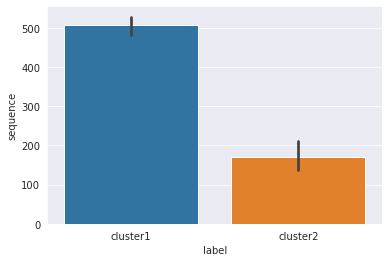

In [44]:
sns.barplot(
    data=df_clusters_sequence_len, 
    x = "label", 
    y = "sequence"
)

<AxesSubplot:xlabel='label', ylabel='sequence'>

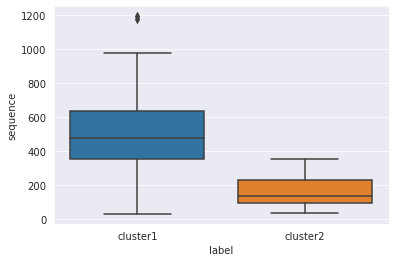

In [45]:
import seaborn as sns
sns.boxplot(
    data=df_clusters_sequence_len, 
    x = "label", 
    y = "sequence"
)

Yes, that seems to be a difference! Why are they so short? The shorter proteins seem to form complexes, for example subcomplexes to the mitochondrial respiratory chain complex (https://www.ebi.ac.uk/pdbe/entry/pdb/7A23). This includes the NADH dehydrogenase in the smaller cluster, but also the NADH-ubiquinone oxidoreductase chains in the larger cluster. If all or most electron transport proteins function in a similar fashion, meaning that they transfer electrons from substrates like NADH to the respiratory chain or similar reactions, then they could make up a good, distinct class for training a model.

How do they differ in terms of aac?

<AxesSubplot:xlabel='Feature', ylabel='Frequency'>

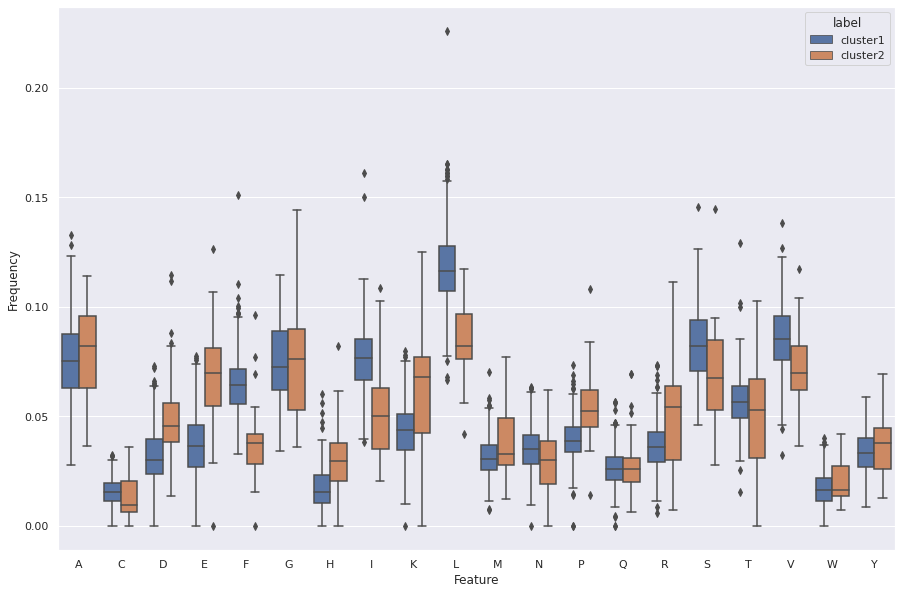

In [57]:
df_clusters_sequences = pd.concat(
    [
        pd.DataFrame(df_cluster1.sequence).assign(label="cluster1"), 
        pd.DataFrame(df_cluster2.sequence).assign(label="cluster2")
    ]
)

df_clusters_aac = calculate_aac(df_clusters_sequences.sequence).assign(label = df_clusters_sequences.label)

df_clusters_aac = df_clusters_aac.reset_index()

df_clusters_aac_long = df_clusters_aac.melt(id_vars=["Uniprot", "label"], value_name="Frequency", var_name="Feature")
sns.set(rc={"figure.figsize":(15, 10)})
sns.boxplot(data=df_clusters_aac_long, x = "Feature", y ="Frequency", hue = "label")

<AxesSubplot:xlabel='Feature', ylabel='Frequency'>

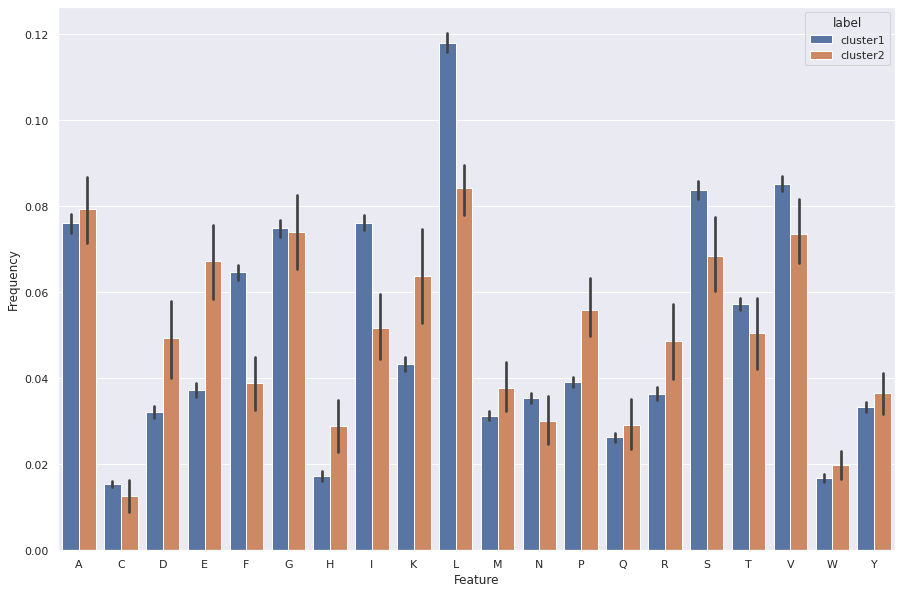

In [58]:
sns.barplot(data=df_clusters_aac_long, x = "Feature", y ="Frequency", hue = "label")

They contain a lot less Leucine, which is a typical amino acid found in transmembrane helices. This matches the Uniprot entries, which often show short sequences with one helix, for example. 

According to the heatmap, there are six proteins in the smaller cluster with less correlation to the remaining dataset than any other proteins. What are those?

In [70]:
df_aac_cluster2 = df_aac.loc[cluster2]

cluster2a, cluster2b = get_clusters(df_aac_cluster2, 2)


df.loc[cluster2b]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SG91,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,UCRQ-1 At3g10860 T7M13.6,"Cytochrome b-c1 complex subunit 8-1, mitochond...",NaN,0.0,3702,MGKQPVKLKAVVYALSPFQQKIMTGLWKDLPEKIHHKVSENWISAT...
Q42342,Electron transport,Cell membrane;Endoplasmic reticulum;Membrane;T...,Transport,CYTB5-E B5-A CB5-A CB5-E At5g53560 MNC6.10,Cytochrome b5 isoform E (AtCb5-E) (Cytochrome ...,NaN,0.0,3702,MSSDRKVLSFEEVSKHNKTKDCWLIISGKVYDVTPFMDDHPGGDEV...
Q9ZNV4,Electron transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,CYTB5-C CB5-C At2g46650 T3A4.3,Cytochrome B5 isoform C (AtCb5-C),NaN,0.0,3702,MANLISFHDVAKHKCKNDCWILIHGKVYDISTFMDEHPGGDNVLLA...
Q9ZWT2,Electron transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,CYTB5-D B5-B CB5-B CB5-D At5g48810 K24G6.14,Cytochrome B5 isoform D (AtCb5-D) (Cytochrome ...,NaN,0.0,3702,MGGDGKVFTLSEVSQHSSAKDCWIVIDGKVYDVTKFLDDHPGGDEV...
O48845,Electron transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,CYTB5-B CB5-B CB5-E At2g32720 F24L7.14,Cytochrome b5 isoform B (AtCb5-B) (Cytochrome ...,NaN,0.0,3702,MGDEAKIFTLSEVSEHNQAHDCWIVINGKVYNVTKFLEDHPGGDDV...
Q9FLB7,Electron transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Respiratory chain;Transport,UCRQ-2 At5g05370 K18I23.18,"Cytochrome b-c1 complex subunit 8-2, mitochond...",NaN,0.0,3702,MGKQPVKLKAVVYALSPFQQKIMTGLWKDLPEKIHHKVSENWISTI...
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...


They are mostly parts of Cytochrome complexes, while one of the GDU proteins is also present. According to Alphafold, they have one transmembrane helix, to which a beta-sheet is attached. That would explain their different AAC. The different AAC, especially the low Leucine content, could be an indicator that these proteins are members of transport complexes, but do not perform the transport themselves. We should try how removing them during the evaluation changes the model fit. 

In [73]:
# pca_plot_2d(df_aac, df.tcdb_class, figsize=(15,10))
print(cluster2)

['Q8RWA7', 'Q9FGK0', 'Q9LXJ2', 'P56779', 'O49313', 'Q9SG91', 'P62095', 'O22048', 'Q39219', 'Q9LK29', 'Q42342', 'Q9ZNV4', 'Q9FKS5', 'O22049', 'O23913', 'Q9ZWT2', 'O48845', 'Q56X52', 'Q9C9Z5', 'Q9FLB7', 'Q9ZR03', 'Q9M9R9', 'O81775', 'Q9SW07', 'Q9FHH5', 'Q8S8A0', 'Q3E965', 'Q3EAV6', 'Q3E8L0']


In [74]:
print(cluster2b)

['Q9SG91', 'Q42342', 'Q9ZNV4', 'Q9ZWT2', 'O48845', 'Q9FLB7', 'Q3EAV6']


## Analysis of the individual substrates

In [75]:
sugar_transporters = df[df.keywords_transport.str.contains("Sugar")]
amino_transporters = df[df.keywords_transport.str.contains("Amino")]
electron_transporters = df[df.keywords_transport.str.contains("Electron")]
potassium_transporters = df[df.keywords_transport.str.contains("Potassium")]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

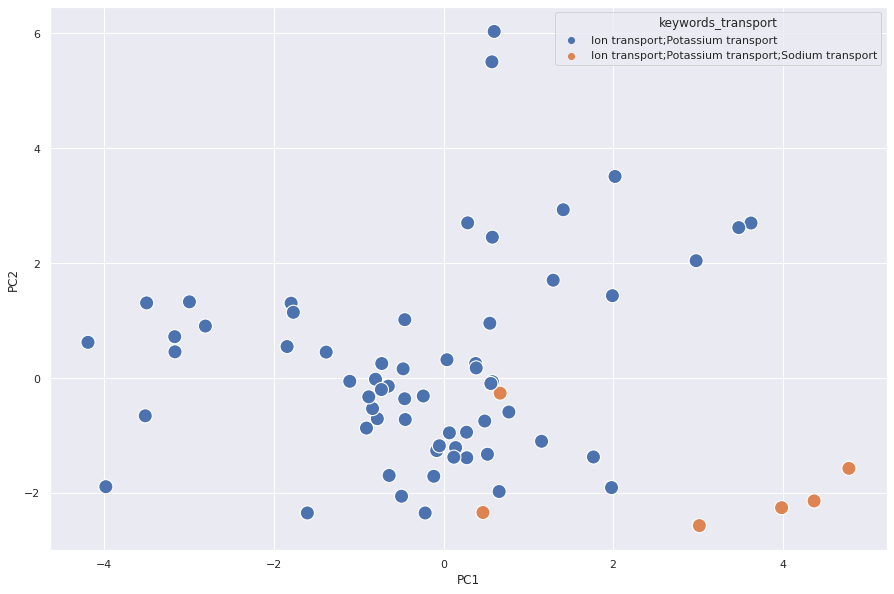

In [92]:
pca_plot_2d(df_aac.loc[potassium_transporters.index], df.loc[potassium_transporters.index].keywords_transport, figsize=(15,10), marker_size=200)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

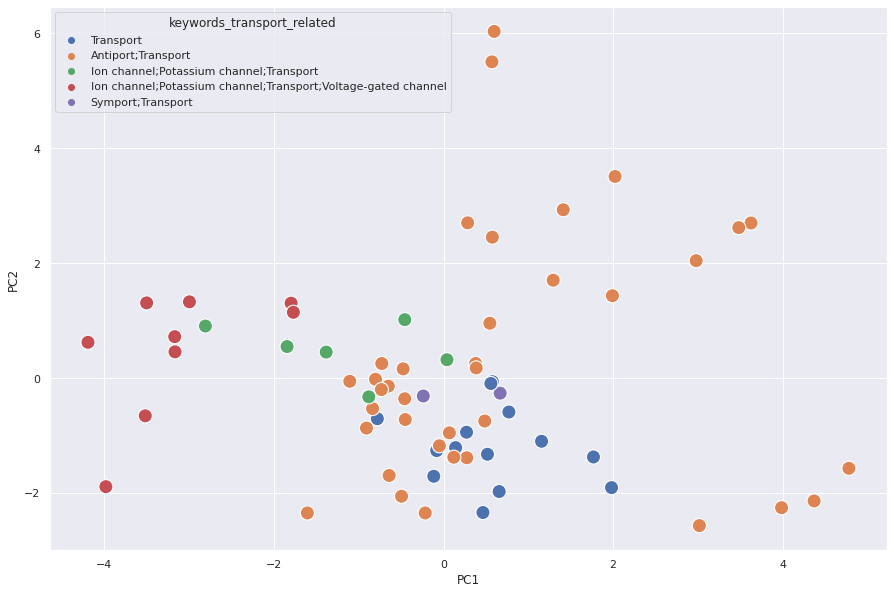

In [91]:
pca_plot_2d(df_aac.loc[potassium_transporters.index], df.loc[potassium_transporters.index].keywords_transport_related, figsize=(15,10), marker_size=200)

The voltage-gated channels seem to show some differences, but according to Alphafold they still have normal 3D structures with alpha-helical bundles. We tried removing them from the dataset in the past, and the evaluation results were very similar to the dataset with them included. 

In [94]:
df[df.keywords_transport_related.str.contains("Ion channel")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9XFR0,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport,KCO3 At5g46360 MPL12.16,Potassium inward rectifier (Kir)-like channel ...,1.A.1.7.6,1.A,3702,MPMTPSEFKNRLLFGSLPRSSSDPTDLQFTEPNVPPSLFSLPEHND...
Q8LBL1,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport,TPK1 KCO1 At5g55630 MDF20.7,Two-pore potassium channel 1 (AtTPK1) (Calcium...,1.A.1.7.3,1.A,3702,MSSDAARTPLLPTEKIDTMAQDFNLNSRTSSSRKRRLRRSRSAPRG...
Q9M8S6,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,SKOR At3g02850 F13E7.21,Potassium channel SKOR (Stelar K(+) outward re...,1.A.1.4.5,1.A,3702,MGGSSGGGVSYRSGGESDVELEDYEVDDFRDGIVESRGNRFNPLTN...
Q38898,Ion transport;Potassium transport,Endoplasmic reticulum;Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,AKT2 AKT3 At4g22200 T10I14.30,Potassium channel AKT2/3,1.A.1.4.6,1.A,3702,MDLKYSASHCNLSSDMKLRRFHQHRGKGREEEYDASSLSLNNLSKL...
Q94A76,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,GORK At5g37500 MPA22.4,Potassium channel GORK (Guard cell outward rec...,1.A.1.4.4,1.A,3702,MGRLRRRQEIIDHEEEESNDDVSSRRGKLSLAETFRWLDSSEHRRI...
Q38849,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,KAT2 At4g18290 T9A21.140,Potassium channel KAT2,1.A.1.4.6,1.A,3702,MSISCTRNFFKRFCVEEYNMDTFKHSSFLSADLLPSLGARINQSTK...
Q9SCX5,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,AKT5 At4g32500 F8B4.200,Probable potassium channel AKT5,NaN,0.0,3702,MGIEKRKKMVWFWPEKHEGGVIKEAEDVAAEHISREGTMSHYSFSK...
Q8GXE6,Ion transport;Potassium transport,Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,AKT6 SPIK At2g25600 F3N11.5,Potassium channel AKT6 (Potassium channel SPIK...,1.A.1.4.8,1.A,3702,MEKKKVWFWGVKDDGEGGGGRGGGRTKDAEDDVADHLSRDGTMSQY...
Q38998,Ion transport;Potassium transport,Cell membrane;Membrane;Transmembrane,Ion channel;Potassium channel;Transport;Voltag...,AKT1 At2g26650 F18A8.2,Potassium channel AKT1,1.A.1.4.1,1.A,3702,MRGGALLCGQVQDEIEQLSRESSHFSLSTGILPSLGARSNRRVKLR...


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

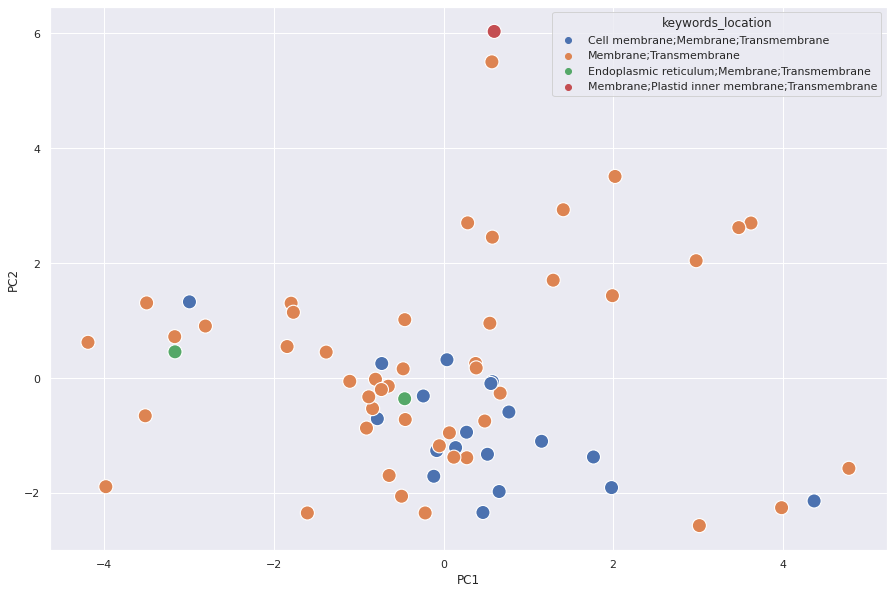

In [93]:
pca_plot_2d(df_aac.loc[potassium_transporters.index], df.loc[potassium_transporters.index].keywords_location, figsize=(15,10), marker_size=200)

## Clustering stats

In [95]:
from subpred.transporter_dataset import get_clustering_stats
df_stats_long = get_clustering_stats(df)

In [96]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

keyword,Amino-acid transport,Electron transport,Ion transport,Potassium transport,Sodium transport,Sugar transport
identity_threshold,,,,,,
40,18,44,29,26,5,36
50,26,49,40,37,5,55
60,32,53,52,47,5,76
70,40,56,60,55,5,84
80,48,61,71,65,5,94
90,53,63,73,67,6,110
100,54,69,76,68,6,118


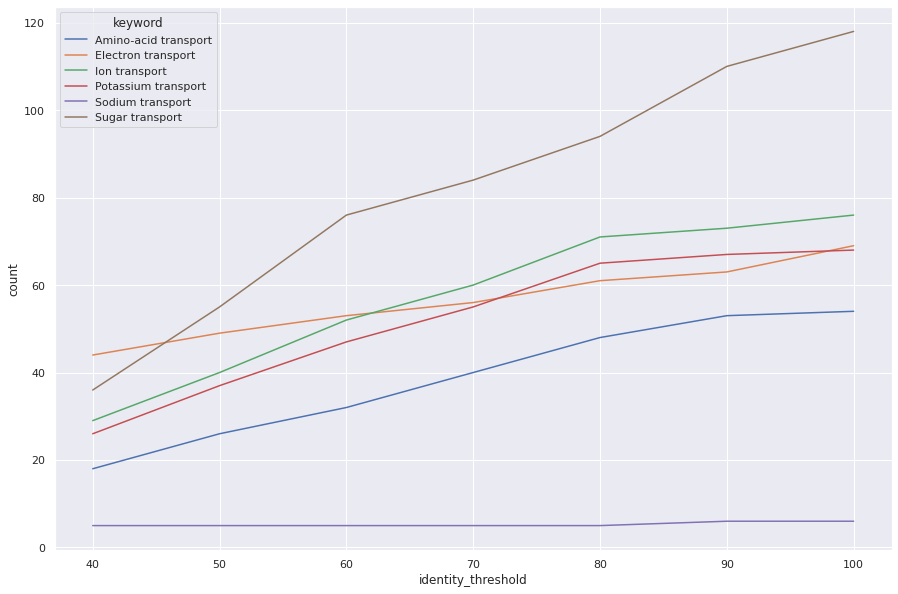

In [97]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

keyword,Cell membrane,Endoplasmic reticulum,Membrane,Mitochondrion,Mitochondrion inner membrane,Nucleus,Plastid inner membrane,Transmembrane
identity_threshold,,,,,,,,
40,21,7,124,22,17,0,1,124
50,34,10,167,22,17,0,1,167
60,48,11,208,23,17,0,1,208
70,54,13,235,25,19,0,1,235
80,65,15,268,27,20,1,2,268
90,73,16,293,28,21,1,2,293
100,77,16,309,32,25,1,2,309


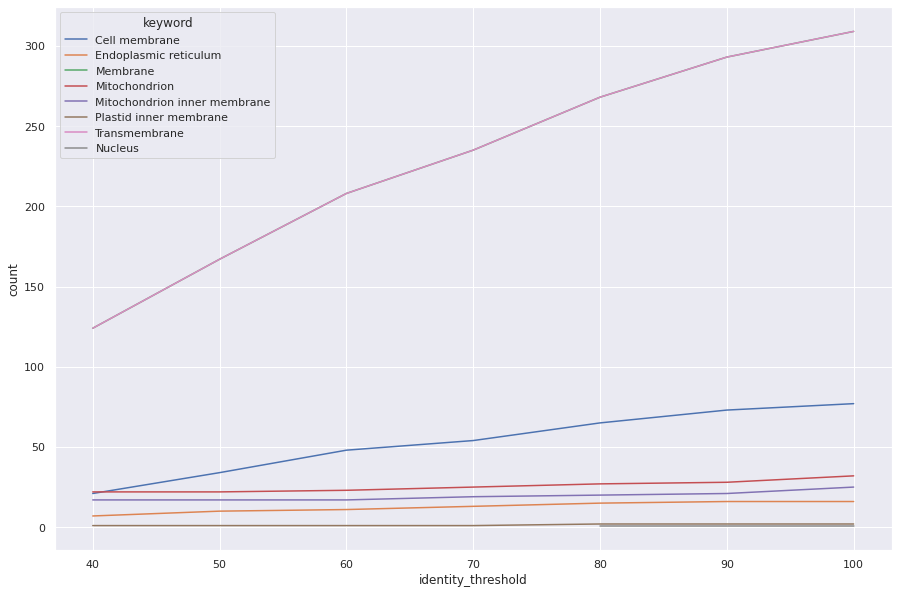

In [98]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

keyword,Antiport,Ion channel,Potassium channel,Respiratory chain,Symport,Transport,Voltage-gated channel
identity_threshold,,,,,,,
40,22,6,6,19,8,124,3
50,30,8,8,19,12,167,5
60,34,11,11,19,21,208,6
70,40,13,13,21,24,235,7
80,47,15,15,22,32,268,9
90,54,15,15,23,40,293,9
100,56,15,15,27,41,309,9


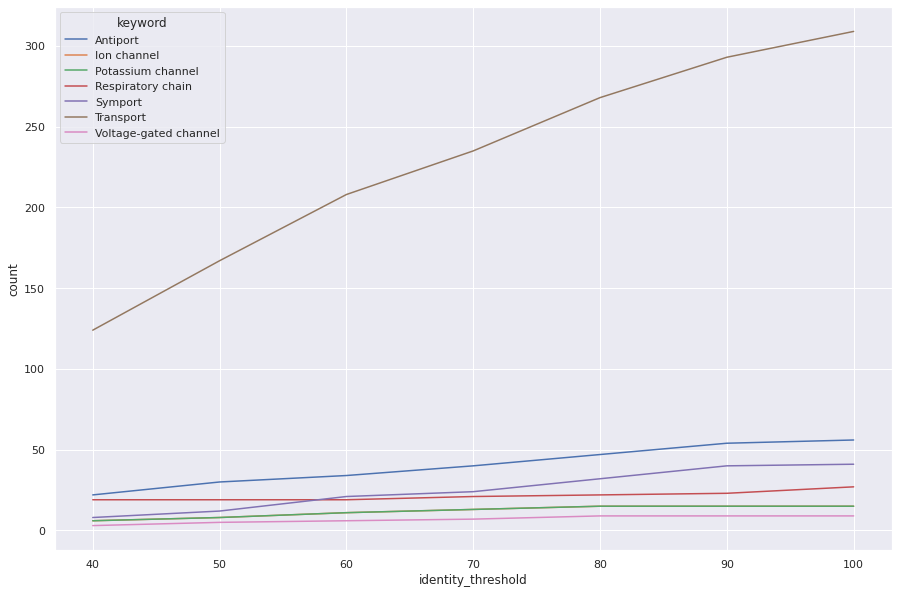

In [99]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

keyword,0.0,1.A,2.A,3.D,5.A,5.B
identity_threshold,,,,,,
40,78,6,31,4,1,4
50,105,8,45,4,1,4
60,133,11,55,4,1,4
70,154,13,59,4,1,4
80,180,14,65,4,1,4
90,195,14,75,4,1,4
100,210,14,76,4,1,4


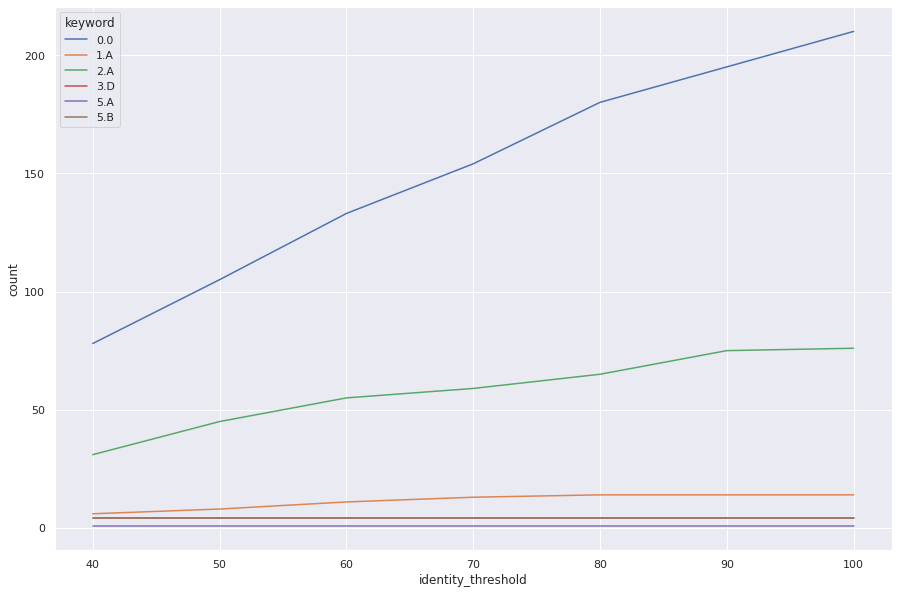

In [100]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

## Conclusion

Keeping the 70% clustering threshold seems to be the best option, since the number of amino-acid transporters still reaches below a threshold of 20 proteins if we go below that threshold. 

We will try two approaches: One without the GDU proteins and without the sodium transporter (the dataset used in the manuscript), as well as a dataset where cluster2 is removed completely. That includes the short protein complex member from the Electron datset, the GDU proteins, and some Cytochrome chains with beta sheets in their sequences.